In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
times = {"cores":[],"mean":[],"meanerr":[],"throughput_GB_s":[]}
timedir = "20211117-singlenode-hl_d101-taskset08152431/appruntimes"

readsize = 225881515200
for f in os.listdir(timedir):
    array = numpy.genfromtxt(timedir+"/"+f, skip_header=1)
    nodes = f.split("_")[5].replace("cores.csv","")
    time_mean = numpy.mean(array)
    times["cores"].append(int(nodes))
    times["mean"].append(round(time_mean, 2))
    times["meanerr"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_GB_s"].append(readsize/time_mean/pow(10, 9))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="cores").reset_index(drop=True).copy()
timesdf = timesdf.iloc[:5,:]
timesdf

,cores,mean,meanerr,throughput_GB_s
0,1,280.87,5.22,0.804230
1,2,150.17,2.19,1.504130
2,4,92.09,1.24,2.452944
3,6,65.72,0.72,3.437267
4,8,52.29,0.86,4.319454


In [3]:
throughput_1node = timesdf["throughput_GB_s"][0]
timesdf["throughputspeedup"] = timesdf["throughput_GB_s"] / throughput_1node
timesdf

,cores,mean,meanerr,throughput_GB_s,throughputspeedup
0,1,280.87,5.22,0.804230,1.000000
1,2,150.17,2.19,1.504130,1.870273
2,4,92.09,1.24,2.452944,3.050052
3,6,65.72,0.72,3.437267,4.273984
4,8,52.29,0.86,4.319454,5.370918


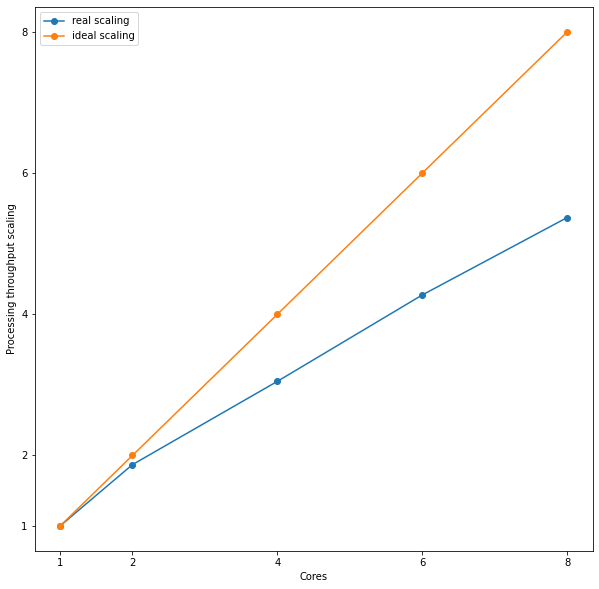

In [4]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughputspeedup"], label="real scaling", marker="o")
pyplot.plot(timesdf["cores"], timesdf["cores"], label="ideal scaling", marker="o")
pyplot.xticks(timesdf["cores"])
pyplot.yticks(timesdf["cores"])
pyplot.xlabel("Cores")
pyplot.ylabel("Processing throughput scaling")
pyplot.legend()

No handles with labels found to put in legend.


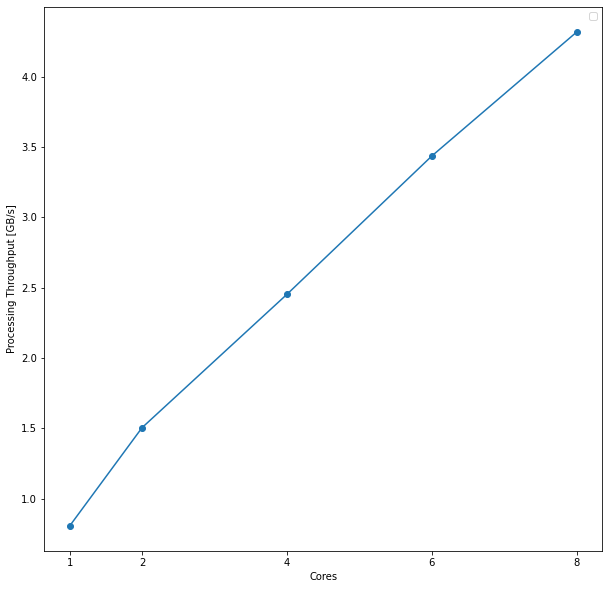

In [5]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughput_GB_s"], marker="o")
pyplot.xticks(timesdf["cores"])

pyplot.xlabel("Cores")
pyplot.ylabel("Processing Throughput [GB/s]")
pyplot.legend()

# RNTuple read throughput

In [6]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211117-singlenode-hl_d101-taskset08152431"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = timedir.split("_")[2].replace("cores","")
    chunks = nodes
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = f.split("_")[1].replace("task","")
        df["taskid"] = int(taskid)
        df["cores"] = int(nodes)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="cores").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,cores
0,288.529,57087619849,3956,225881515200,0,1
1,264.929,41341207639,5463,225881515200,0,1
2,264.093,41491083937,5444,225881515200,0,1
3,261.157,41372364876,5459,225881515200,0,1
4,315.316,55444769449,4073,225881515200,0,1
...,...,...,...,...,...,...
652,40.243,16804558781,840,14117594700,2,16
653,40.706,20075156039,703,14117594700,2,16
654,38.604,15697661788,899,14117594700,2,16
655,40.500,17918005434,787,14117594700,0,16


In [7]:
meantaskthroughput = df.groupby(["cores"]).mean()[["taskruntime","taskreadtime","readthroughput","readpayload"]]
meantaskthroughput = meantaskthroughput.reset_index().sort_values("cores").reset_index(drop=True)
meantaskthroughput["taskreadtime_s"] = meantaskthroughput["taskreadtime"] / pow(10, 9) # nanoseconds
meantaskthroughput

,cores,taskruntime,taskreadtime,readthroughput,readpayload,taskreadtime_s
0,1,280.732889,4.788282e+10,4823.333333,2.258815e+11,47.882816
1,2,146.585500,2.811672e+10,4114.833333,1.129408e+11,28.116719
2,4,87.719194,1.335301e+10,4303.861111,5.647038e+10,13.353013
3,6,62.915426,1.073064e+10,3572.129630,3.764692e+10,10.730644
4,8,48.776194,8.180422e+09,3509.694444,2.823519e+10,8.180422
5,10,44.223222,7.474832e+09,3069.388889,2.258815e+10,7.474832
6,12,41.985667,6.584649e+09,2921.694444,1.882346e+10,6.584649
7,14,39.848000,7.698375e+09,2219.706349,1.613439e+10,7.698375
8,16,40.768444,1.755655e+10,807.076389,1.411759e+10,17.556546


Text(0, 0.5, 'Average Task Throughput [MB/s]')

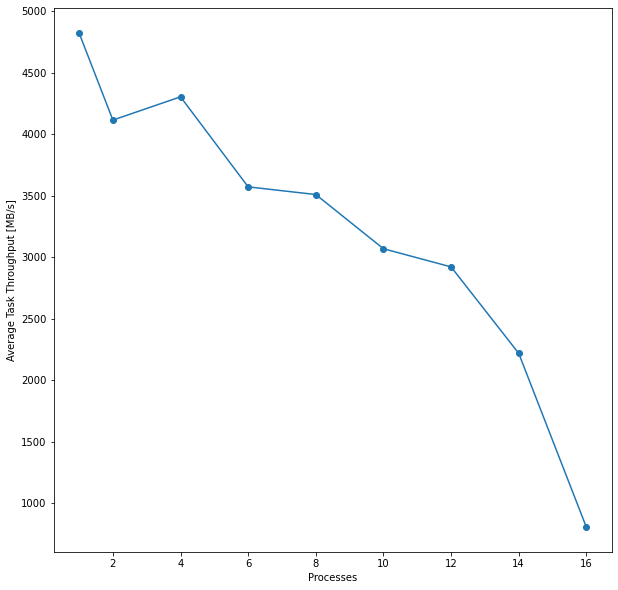

In [8]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["readthroughput"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Average Task Throughput [MB/s]")

Text(0, 0.5, 'Time [s]')

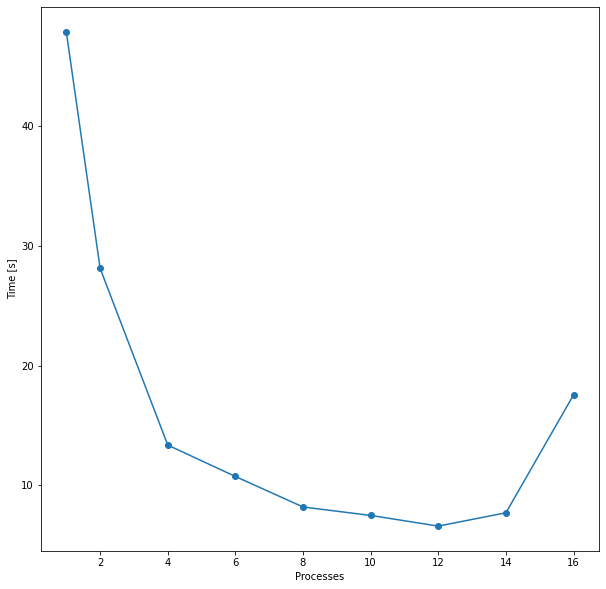

In [9]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["taskreadtime_s"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Time [s]")

In [10]:
sumthroughput = df.groupby(["cores","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["cores"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / pow(10, 3)
sumthroughput[["cores","readthroughput","readpayload"]]

,cores,readthroughput,readpayload
0,1,4823.333333,2.258815e+11
1,2,8229.666667,2.258815e+11
2,4,17215.444444,2.258815e+11
3,6,21432.777778,2.258815e+11
4,8,28077.555556,2.258815e+11
5,10,30693.888889,2.258815e+11
6,12,35060.333333,2.258815e+11
7,14,31075.888889,2.258815e+11
8,16,12913.222222,2.258815e+11


Text(0, 0.5, 'Read Throughput [GB/s]')

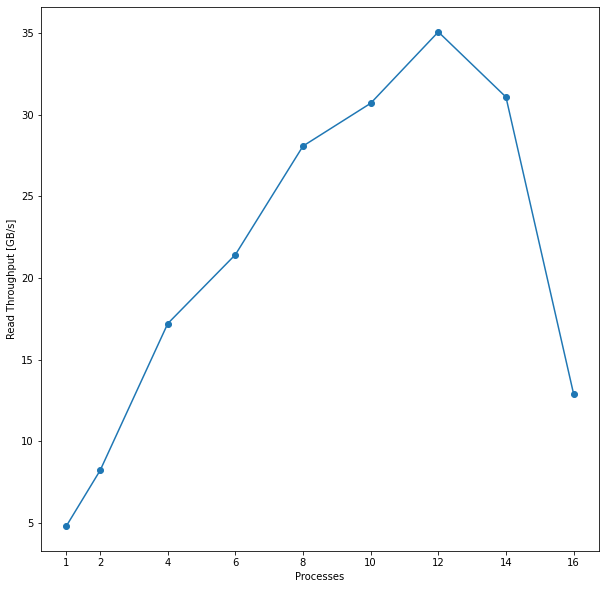

In [11]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["readthroughput"]/1000, marker="o")
pyplot.xlabel("Processes")
pyplot.xticks(sumthroughput["cores"])
pyplot.ylabel("Read Throughput [GB/s]")

# TGraph

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughput.png has been created


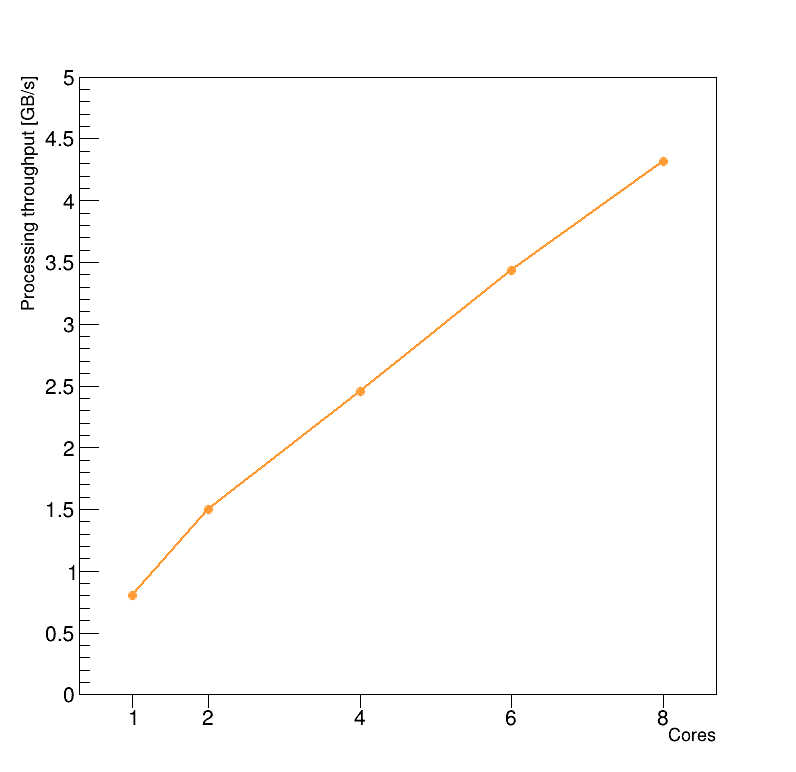

In [12]:
runtimegraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Processing throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 5)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(timesdf["cores"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_processingthroughput.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughputspeedup.png has been created


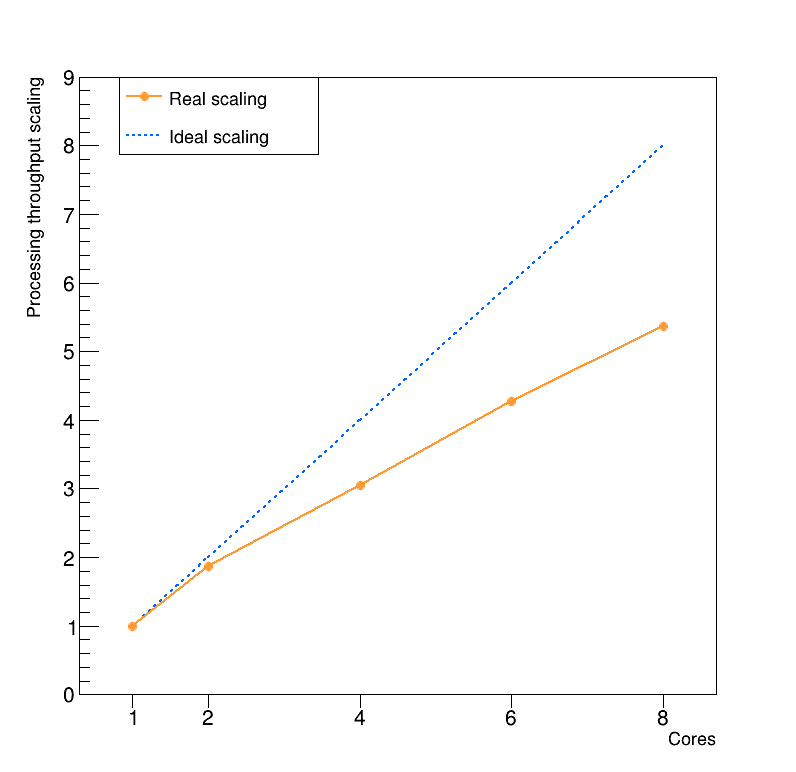

In [21]:
speedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["cores"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Processing throughput scaling")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 9)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["cores"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -0.45, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(speedupgraph, "Real scaling")
legend.AddEntry(idealspeedupgraph, "Ideal scaling", "L")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.025)

c.Draw()
c.SaveAs("distrdf_lhcb_singlenode_processingthroughputspeedup.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_readthroughput.png has been created


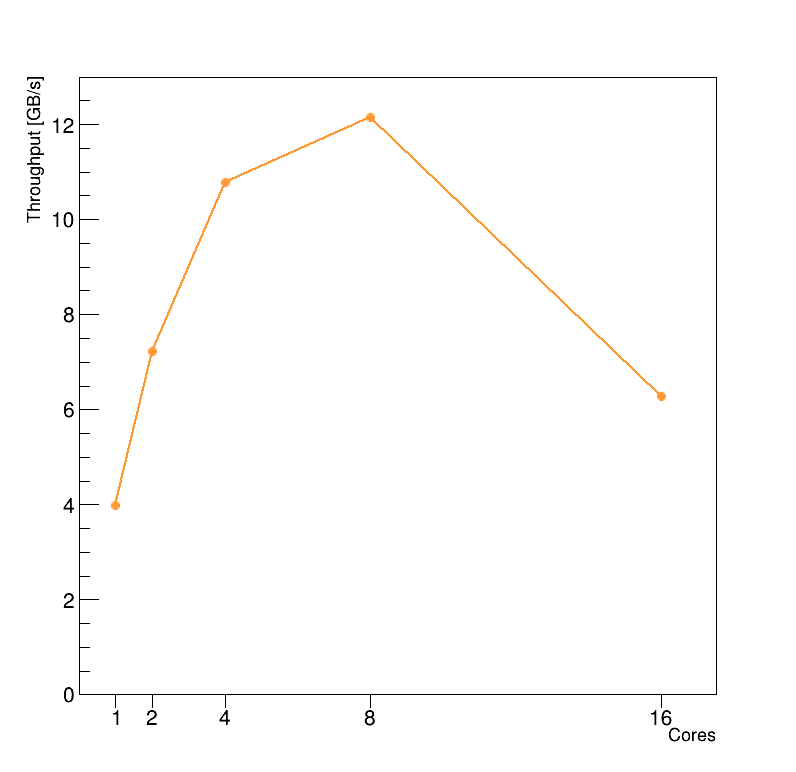

In [150]:
runtimegraph = ROOT.TGraph(len(sumthroughput["cores"]), numpy.array(sumthroughput["cores"], dtype=float), numpy.array(sumthroughput["readthroughput"]/1000, dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 13)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(sumthroughput["cores"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_readthroughput.png")